In [23]:
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import pandas as pd
import scipy as sp
import scipy.signal as ss

plt.style.use('seaborn-notebook')
np.random.seed(293710966)

In [2]:
from IPython.display import display, Math

def mprint(s):
    display(Math(s))

# Esempio 3.8

## Generazione Segnale

In [3]:
time = np.arange(200)

### Rumore
L'esercizio prevede un segnale con potenza
$\hat{\sigma}_w^2 = 1.0$.

> **Domanda:** come genero un rumore bianco data la sua potenza?

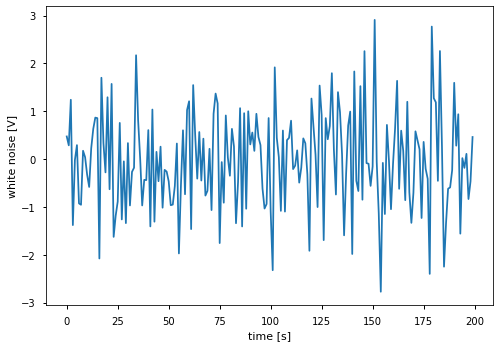

In [4]:
noise = np.random.normal(0, 1, size=time.size)

ax = plt.axes()
ax.plot(time, noise)
ax.set_xlabel('time [s]')
ax.set_ylabel('white noise [V]');

### Armoniche
Frequenza di Potenza, Ampiezze e Fasi sono fornite dall'esercizio, mentre la frequenza di campionamento è ricavata empiricamente confrontando il grafico ottenuto con quello del libro. Il segnale ottenuto è però diverso da quello del libro.
$$
x(n) = \sum_{k=2}^7 a_{2k-1} \, cos \left(2 \pi n (2k-1)
       \frac{f_0}{f_s} + \phi_{2k-1} \right) + w(n)
$$

> **Domanda**: è corretto dire che la frequenza di campionamento non è specificata nel libro?

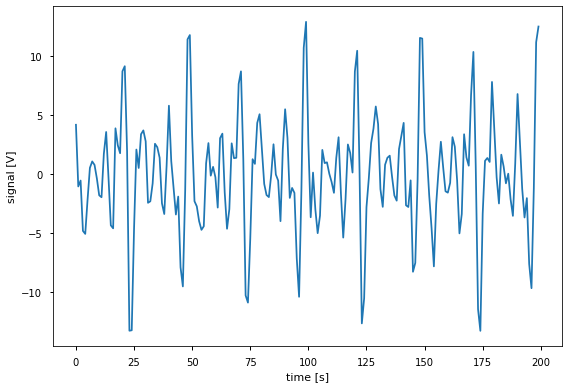

In [5]:
magnitudes = pd.read_csv('./harmonic-voltage-magnitude.csv', index_col='number')
phases = pd.read_csv('./phases.csv', index_col='number')
phases = np.radians(phases)

power_freq = 50
sampling_freq = 2500
    
signal = noise.copy()

for k in range(2, 8):
    n = 2 * k - 1
    amp = magnitudes.typical[n]
    omega = 2 * np.pi * n * power_freq / sampling_freq
    phase = phases['3.8'][n]
    signal += amp * np.cos(omega * time + phase)

fig, ax = plt.subplots()
ax.plot(time, signal)
ax.set_xlabel('time [s]')
ax.set_ylabel('signal [V]')
fig.tight_layout()

## Finestre
Ho scelto la dimensione della finestra in modo completamente arbitrario, ripettando solo il vincolo $M > K$.

> **Domanda:** Esiste un criterio per la scelta della finestra oppure vado a tentativi?

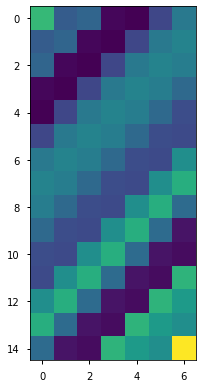

In [6]:
time_window = 7
data_size = signal.size - time_window + 1

windows = [signal[i : i + time_window] for i in range(data_size)]
data_matrix = np.vstack(windows)

fig, ax = plt.subplots()
ax.imshow(data_matrix[:15])
fig.tight_layout()

## Matrice di Autorcorrelazione
$$
\hat{R}_v = \frac{1}{N} \mathbb{V}^H \mathbb{V}
$$

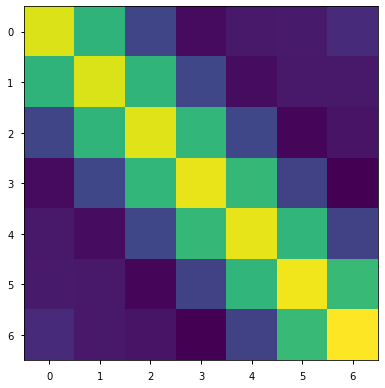

In [7]:
correlation = data_matrix.conj().T @ data_matrix / data_size

fig, ax = plt.subplots()
ax.imshow(correlation)
fig.tight_layout()

## Principal Component Analysis

In [8]:
unsorted_pca = LA.eig(correlation)
pca = sorted(zip(*unsorted_pca), key=itemgetter(0), reverse=True)

signal_pca = list(zip(*pca[:6]))
noise_pca = list(zip(*pca[6:]))

Stima della potenza del rumore in funzione degli autovalori appartenenti al sottospazio del rumore:
$$
\hat{\sigma}_w^2 = \frac{1}{M - K} \sum_{i=K+1}^M \lambda_i
$$

In [9]:
noise_power = sum(noise_pca[0]) / (time_window - 6)

mprint(f'\hat{{\sigma}}_w^2 = {noise_power:.3f}')

<IPython.core.display.Math object>

## MUSIC
$$
P_{music}(e^{j\omega}) = \frac{1}{\sum_{i=K+1}^M |e^H s_i|^2}
$$

> **Problema:** Il pseudo-spettro non è per niente simile a quello del libro.

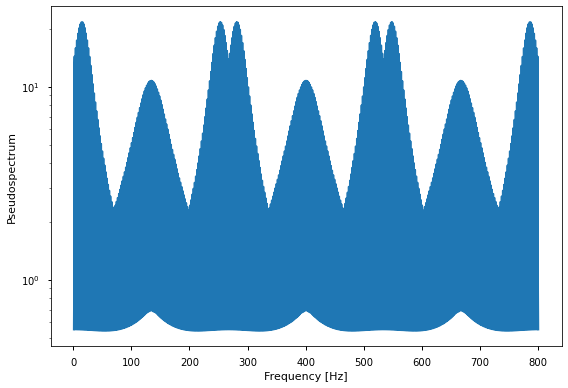

In [10]:
noise_eig = np.array(noise_pca[1])

freqs = np.linspace(1, 800, 2000)
omegas =  2 * np.pi * freqs
power_music = np.empty_like(omegas)

for i, omega in enumerate(omegas):
    steering = np.exp(1j * omega * np.arange(time_window))
    power_music[i] = 1 / np.sum(np.abs(noise_eig @ steering) ** 2)
    
fig, ax = plt.subplots()
ax.plot(freqs, power_music)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Pseudospectrum')
ax.set_yscale('log')
fig.tight_layout()

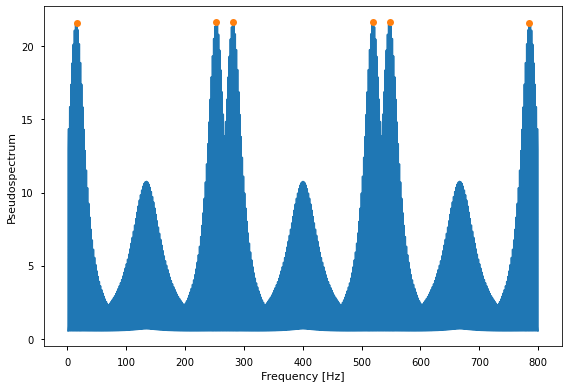

In [11]:
# power_music[:3] = 0
peaks, _ = ss.find_peaks(power_music)

music_peaks = peaks[np.argsort(power_music[peaks])][-6:]

fig, ax = plt.subplots()
ax.plot(freqs, power_music)
ax.plot(freqs[music_peaks], power_music[music_peaks], 'o');
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Pseudospectrum')
# ax.set_yscale('log')
fig.tight_layout()

In [12]:
est_omegas = omegas[music_peaks]
harmonic_numbers = est_omegas / (2 * np.pi * 50)
np.sort(np.around(harmonic_numbers))

array([ 0.,  5.,  6., 10., 11., 16.])

# Esempio 3.9

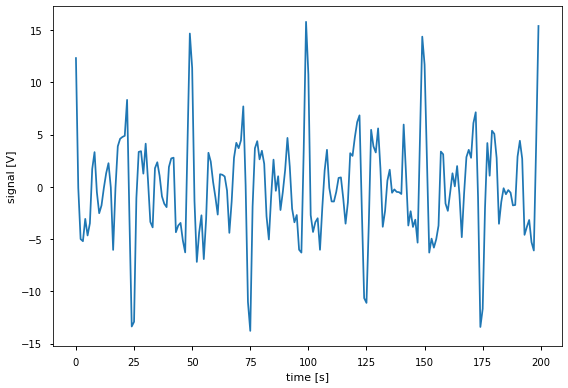

In [13]:
power_freq = 50
sampling_freq = 2500
    
signal = noise.copy()

for n in range(2, 14):
    amp = magnitudes.typical[n]
    omega = 2 * np.pi * n * power_freq / sampling_freq
    phase = phases['3.9'][n]
    signal += amp * np.cos(omega * time + phase)

fig, ax = plt.subplots()
ax.plot(time, signal)
ax.set_xlabel('time [s]')
ax.set_ylabel('signal [V]')
fig.tight_layout()

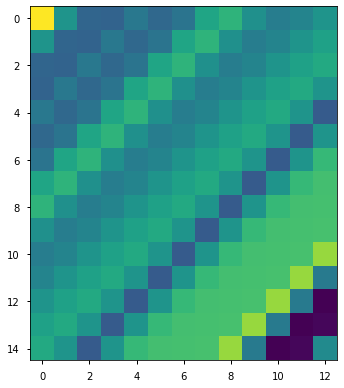

In [14]:
time_window = magnitudes.typical.size + 1
data_size = signal.size - time_window + 1

windows = [signal[i : i + time_window] for i in range(data_size)]
data_matrix = np.vstack(windows)

fig, ax = plt.subplots()
ax.imshow(data_matrix[:15])
fig.tight_layout()

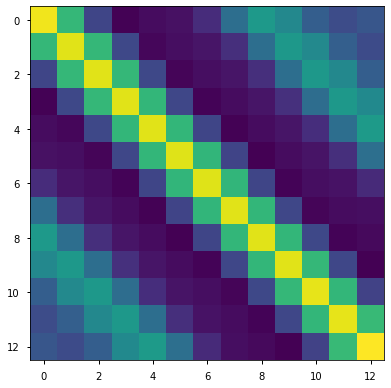

In [15]:
correlation = data_matrix.conj().T @ data_matrix / data_size

fig, ax = plt.subplots()
ax.imshow(correlation)
fig.tight_layout()

In [22]:
unsorted_pca = LA.eig(correlation)
pca = sorted(zip(*unsorted_pca), key=itemgetter(0), reverse=True)

signal_pca = list(zip(*pca[:magnitudes.typical.size]))
noise_pca = list(zip(*pca[magnitudes.typical.size:]))

In [17]:
noise_power = sum(noise_pca[0]) / (time_window - magnitudes.typical.size)

mprint(f'\hat{{\sigma}}_w^2 = {noise_power:.3f}')

<IPython.core.display.Math object>

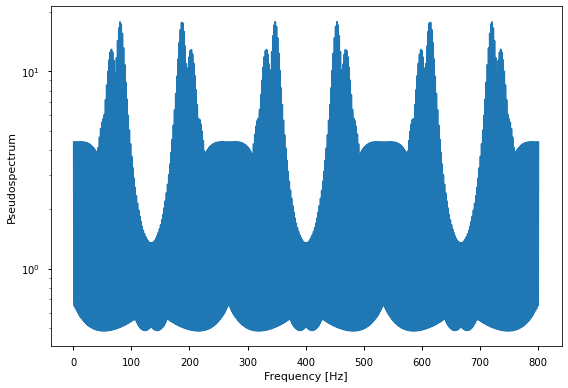

In [18]:
noise_eig = np.array(noise_pca[1])

freqs = np.linspace(1, 800, 2000)
omegas =  2 * np.pi * freqs
power_music = np.empty_like(omegas)

for i, omega in enumerate(omegas):
    steering = np.exp(1j * omega * np.arange(time_window))
    power_music[i] = 1 / np.sum(np.abs(noise_eig @ steering) ** 2)
    
fig, ax = plt.subplots()
ax.plot(freqs, power_music)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Pseudospectrum')
ax.set_yscale('log')
fig.tight_layout()

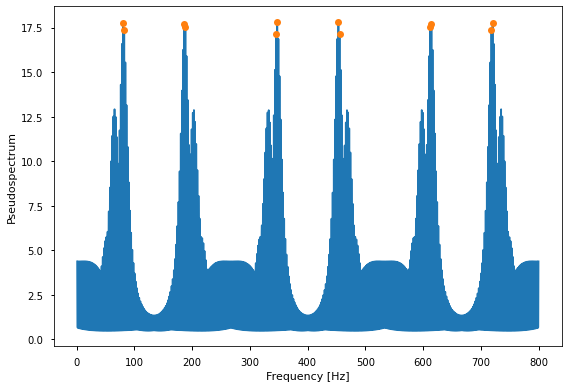

In [19]:
peaks, _ = ss.find_peaks(power_music)

music_peaks = peaks[np.argsort(power_music[peaks])][-len(magnitudes):]

fig, ax = plt.subplots()
ax.plot(freqs, power_music)
ax.plot(freqs[music_peaks], power_music[music_peaks], 'o');
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Pseudospectrum')
# ax.set_yscale('log')
fig.tight_layout()

In [20]:
est_omegas = omegas[music_peaks]
harmonic_numbers = est_omegas / (2 * np.pi * 50)
np.sort(np.around(harmonic_numbers))

array([ 2.,  2.,  4.,  4.,  7.,  7.,  9.,  9., 12., 12., 14., 14.])